In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
DNAME = "FoodData_Central_csv_2020-04-29/"

In [2]:
train = pd.read_csv(DNAME+"train_reduced.csv").set_index("fdc_id")
y_train=train["is_meat"]
x_train=train.drop("is_meat",axis=1)
x_test = pd.read_csv(DNAME+"x_test.csv").set_index("fdc_id")
y_test = pd.read_csv(DNAME+"y_test_meat_target.csv").set_index("fdc_id")

In [3]:
x_test=x_test[x_train.columns]
x_test.shape

(34308, 183)

In [4]:
params = {"max_depth":range(3,23,5),
          "n_estimators":[100,300,500],
          "ccp_alpha":[0,.001]
         }

In [5]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
gs = GridSearchCV(estimator=rfc, param_grid=params,scoring="recall",cv=10,verbose=1,n_jobs=-1)



In [6]:
gs.fit(x_train, y_train.values.ravel())

Fitting 10 folds for each of 24 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 11.3min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed: 15.5min finished


GridSearchCV(cv=10, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'ccp_alpha': [0, 0.001], 'max_depth': range(3, 23, 5),
                         'n_estimators': [100, 300, 500]},
             scoring='recall', verbose=1)

In [7]:
gs.best_estimator_

RandomForestClassifier(ccp_alpha=0, max_depth=18, n_estimators=500)

In [8]:
gs

GridSearchCV(cv=10, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'ccp_alpha': [0, 0.001], 'max_depth': range(3, 23, 5),
                         'n_estimators': [100, 300, 500]},
             scoring='recall', verbose=1)

In [9]:
from sklearn import metrics
gs_pred = gs.predict(x_test)
gs_recall = metrics.recall_score(y_test, gs_pred)
gs_recall

0.9845256784032295

In [10]:
gs_f1 = metrics.f1_score(y_test, gs_pred)
gs_acc = metrics.accuracy_score(y_test, gs_pred)
gs_recall = metrics.recall_score(y_test, gs_pred)
gs_prec = metrics.precision_score(y_test, gs_pred)

print('f1,recall,acc,prec score: ', gs_f1,gs_acc,gs_recall,gs_prec)

f1,recall,acc,prec score:  0.7794744318181819 0.9275970619097587 0.9845256784032295 0.6451138868479059


In [11]:
gs_pred

array([0, 0, 0, ..., 0, 0, 1])

In [12]:
y_test["prediction"]=gs_pred
errors = y_test[y_test["is_meat"]!=y_test["prediction"]]
#errors

In [14]:
food_merge = pd.read_csv(DNAME+"food_merge.csv").set_index("fdc_id")
pd.set_option('display.min_rows', 10)
full_error=pd.concat([errors,food_merge.loc[errors.index]["description"]],axis=1)
full_error[full_error["is_meat"]==1]

,is_meat,prediction,description
fdc_id,,,
516858,1,0,THAI CURRY
507762,1,0,ORGANIC VEGETARIAN CHILI
333411,1,0,"Proximates, Pollock, raw (IN) - NFY060DN7"
805661,1,0,CRAWFISH SHRIMP & CRAB BOIL
389247,1,0,VEGETARIAN CHILI 3 BEAN CHIPOTLE
...,...,...,...
742802,1,0,ORIGINALS PANINO GENOA SALAMI WRAPPED MOZZAREL...
593903,1,0,SCREAMIN' JALAPENO BEEF & CHEESE MEAT SNACKS
534830,1,0,SPICY VEGGIE BREAKFAST SAUSAGE


In [15]:
pd.set_option('display.min_rows', 20)
full_error[full_error["is_meat"]==0].iloc[[0,2,4,7]].reset_index()

,fdc_id,is_meat,prediction,description
0,330239,0,1,"Yogurt, Greek, strawberry, non-fat, DANNON OIK..."
1,329933,0,1,"Greek yogurt, FAGE PLAIN NONFAT (CO1,CT1) - CY..."
2,322099,0,1,"Milk, 1%"
3,319905,0,1,"HUMMUS, SABRA CLASSIC"


In [16]:
# looks like the false positives are eggy foods and a couple other high protein things,
# but the false negatives look like things that are actually negative and got mislabeled
# when classifying the labels - like bollywood burger is a vegetarian burger, and vegan
# bacon. There still are some real false negatives but its even less than the stats indicate

In [17]:
full_error[full_error["is_meat"]==1].iloc[[0,2,3,4]].reset_index()

,fdc_id,is_meat,prediction,description
0,516858,1,0,THAI CURRY
1,333411,1,0,"Proximates, Pollock, raw (IN) - NFY060DN7"
2,805661,1,0,CRAWFISH SHRIMP & CRAB BOIL
3,389247,1,0,VEGETARIAN CHILI 3 BEAN CHIPOTLE


In [18]:
egg_index= food_merge[food_merge["food_category_id"]==1].index
egg_index

Int64Index([167687, 167688, 167697, 167703, 167705, 167716, 167730, 167735,
            168089, 168097,
            ...
            790499, 790500, 790501, 790502, 790503, 790504, 790505, 790506,
            790507, 790508],
           dtype='int64', name='fdc_id', length=6697)

In [20]:
y_test

,is_meat,prediction
fdc_id,,
696672,0,0
682742,0,0
492040,0,0
570543,1,1
438661,0,0
561061,0,0
558552,0,0
616886,0,0
670114,0,0


In [21]:
# egg and dairy code is 1 so we can get the index of egg and dairys using that
egg_index = food_merge[food_merge["food_category_id"]==1].index
egg_test = [i for i in egg_index if i in x_test.index]
gs_pred_egg = gs.predict(x_test.loc[egg_test])
display(metrics.accuracy_score(y_test.loc[egg_test]["is_meat"], gs_pred_egg))
display(metrics.recall_score(y_test.loc[egg_test]["is_meat"], gs_pred_egg))

0.3448275862068966

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.0

In [22]:
# all the errors are false positives for dairy products... oh obviously 
# at least theres still pretty high accuracy for dairy

In [23]:
"""test_egg=y_test.loc[egg_test].astype(int)
display(a.shape)
egg_prediction=pd.DataFrame(gs_pred_egg)
egg_prediction.index=test_egg.index
pd.concat([a, b],axis=1)"""

'test_egg=y_test.loc[egg_test].astype(int)\ndisplay(a.shape)\negg_prediction=pd.DataFrame(gs_pred_egg)\negg_prediction.index=test_egg.index\npd.concat([a, b],axis=1)'

In [24]:
# false negatives
false_negatives_i = full_error[full_error["is_meat"]==1].index
false_positives_i = full_error[full_error["is_meat"]==0].index

In [25]:
false_negatives = food_merge.loc[false_negatives_i]
false_positives = food_merge.loc[false_positives_i]
pd.set_option('display.min_rows', 15)
pd.set_option('display.max_rows', 20)
false_negatives

,data_type,description,food_category_id,publication_date,branded_food_category
fdc_id,,,,,
516858,branded_food,THAI CURRY,NaN,2019-04-01,Other Meats
507762,branded_food,ORGANIC VEGETARIAN CHILI,NaN,2019-04-01,Chili & Stew
333411,sub_sample_food,"Proximates, Pollock, raw (IN) - NFY060DN7",15.0,2019-04-01,NaN
805661,branded_food,CRAWFISH SHRIMP & CRAB BOIL,NaN,2020-04-01,Fish & Seafood
389247,branded_food,VEGETARIAN CHILI 3 BEAN CHIPOTLE,NaN,2019-04-01,Chili & Stew
535048,branded_food,OVEN CRISPY JUMBO COCONUT SHRIMP,NaN,2019-04-01,Frozen Fish & Seafood
518511,branded_food,STUFFED CABBAGE,NaN,2019-04-01,Chili & Stew
...,...,...,...,...,...
446413,branded_food,"PROMISE, LOW FAT WHITE LOAF",NaN,2019-04-01,Other Meats


In [26]:
total_label_cnt = food_merge.loc[x_test.index].groupby("branded_food_category").count()["data_type"] 
total_label_cnt

branded_food_category
Bacon, Sausages & Ribs                  214
Breads & Buns                          1738
Cakes, Cupcakes, Snack Cakes           1237
Canned Fruit                            563
Canned Tuna                             185
Canned Vegetables                       775
Cereal                                 1398
                                       ... 
Pickles, Olives, Peppers & Relishes    1708
Powdered Drinks                         609
Pre-Packaged Fruit & Vegetables         808
Sausages, Hotdogs & Brats               646
Soda                                   1242
Water                                   955
Yogurt                                 1195
Name: data_type, Length: 31, dtype: int64

In [27]:
false_neg_grp = false_negatives.groupby("branded_food_category").count()
falsen_percent = false_neg_grp.merge(total_label_cnt,left_index=True,right_index=True,how="left")
falsen_percent["per_fneg"] = falsen_percent["data_type_x"]/falsen_percent["data_type_y"]
falsen_percent = falsen_percent[["per_fneg","data_type_x","data_type_x"]]
falsen_percent.columns = ["per_fneg", "fneg_cnt", "total_cnt"]

In [28]:
false_pos_grp = false_positives.groupby("branded_food_category").count()
falsep_percent = false_pos_grp.merge(total_label_cnt,left_index=True,right_index=True,how="left")
falsep_percent["per_fpos"] = falsep_percent["data_type_x"]/falsep_percent["data_type_y"]
falsep_percent = falsep_percent[["per_fpos","data_type_x","data_type_y"]]
falsep_percent.columns = ["per_fpos", "fpos_cnt", "total_cnt"]

In [29]:
falsen_percent

,per_fneg,fneg_cnt,total_cnt
branded_food_category,,,
Chili & Stew,0.121359,25,25
Fish & Seafood,0.026316,5,5
Frozen Fish & Seafood,0.009398,5,5
Other Meats,0.052117,16,16
"Pepperoni, Salami & Cold Cuts",0.011976,10,10
"Sausages, Hotdogs & Brats",0.001548,1,1


In [30]:
falsep_percent

,per_fpos,fpos_cnt,total_cnt
branded_food_category,,,
Breads & Buns,0.002301,4,1738
"Cakes, Cupcakes, Snack Cakes",0.000808,1,1237
Canned Fruit,0.001776,1,563
Canned Vegetables,0.006452,5,775
Cereal,0.001431,2,1398
Cheese,0.017094,48,2808
Cookies & Biscuits,0.000507,1,1972
"Energy, Protein & Muscle Recovery Drinks",0.003390,1,295
"French Fries, Potatoes & Onion Rings",0.014599,2,137


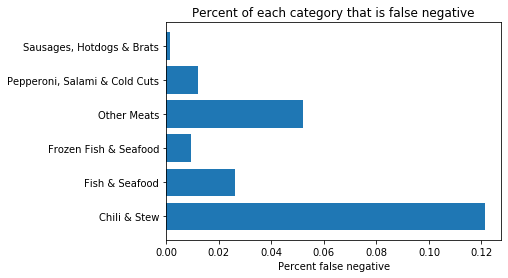

In [31]:
# ok they're all branded foods so this is easier
plt.barh(false_neg_grp.index,falsen_percent["per_fneg"])
plt.title("Percent of each category that is false negative")
plt.xlabel("Percent false negative")
# this is cutting left edge so guess we're screenshotting :)
plt.savefig("figs/"+"fneg_percent")

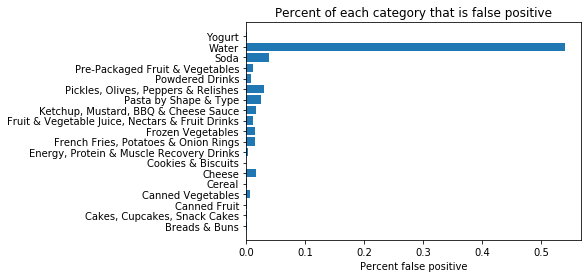

In [32]:
# ok they're all branded foods so this is easier
plt.barh(false_pos_grp.index,falsep_percent["per_fpos"])
plt.title("Percent of each category that is false positive")
plt.xlabel("Percent false positive")
plt.savefig("figs/"+"fpos_percent")

In [33]:
# welp we're getting massive errors with water now for some reason, so once that gets fixed
# the model should do pretty well